In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

torch.manual_seed(0)

In [2]:
torch.cuda.is_available()

True

In [3]:
def get_grav_potential_energy(x, m, G):
    """
    Calculate the total gravitational potential energy of the system.
        x: (n, 2) array of positions
        m: (n,) array of masses
        G: gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and m.shape == (n,)
    epsilon = 20  # For buffering/smoothing effect

    # Calculate pairwise displacement vectors (x_i - x_j)
    dx = x[:, None, :] - x[None, :, :]  # Shape: (n, n, 2)
    d = torch.norm(dx, dim=2)  # Shape: (n, n)

    m_pairwise = m[:,None] * m[None,:]  # Shape: (n, n)

    U_pairwise = -G * m_pairwise / (d + epsilon)  # Shape: (n, n)
    U_pairwise = U_pairwise * (1 - torch.eye(n, dtype=torch.float32, device=x.device))

    # Sum all pairwise potentials and divide by 2 to avoid double-counting
    U_total = torch.sum(U_pairwise) / 2

    return U_total

In [4]:
file = "n_512_G_20_dt_0.1_F_512/cloud/000000.pt"

timeline = torch.load(f"./data/{file}", weights_only=True)
dt, G, m, X, V = [timeline[key] for key in ["dt", "G", "m", "X", "V"]]

X = X.cpu()
sqrt_m = torch.sqrt(m)

F, n, _ = X.shape
# F is number of frames
# n is number of particles

In [5]:
KE_hist = np.sum(1/2 * np.broadcast_to(m[None,:], (F, n)) * np.linalg.norm(V, axis=2)**2, axis=1)
PE_hist = np.array([get_grav_potential_energy(X[i], m, G) for i in range(F)])

Parameters: n=512, G=20, dt=0.1, F=512
Total energy drift: -317084.781 -> -322814.938 (1.807%)


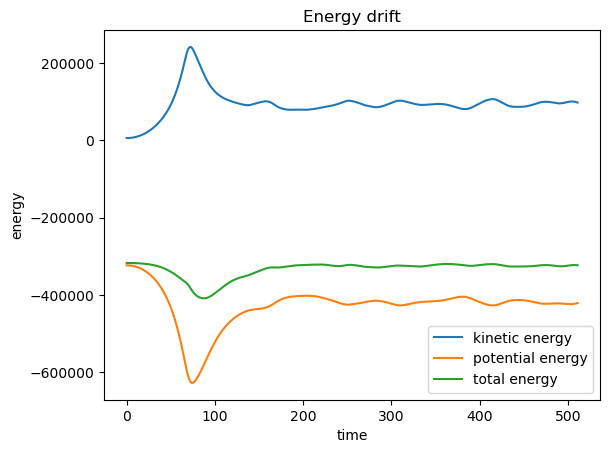

In [6]:
tot_E_hist = KE_hist + PE_hist

plt.plot(KE_hist, label="kinetic energy")
plt.plot(PE_hist, label="potential energy")
plt.plot(tot_E_hist, label="total energy")
plt.xlabel("time")
plt.ylabel("energy")
plt.title("Energy drift")
plt.legend();

print(f"Parameters: n={n}, G={G}, dt={dt}, F={F}")
print(f"Total energy drift: {tot_E_hist[0]:.3f} -> {tot_E_hist[-1]:.3f} ({abs((tot_E_hist[-1] - tot_E_hist[0]) / tot_E_hist[0]) * 100:.3f}%)")